Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


## Test P2 (2023/1): Discrete and continuous mdof systems

---

**NAME:** <br/>
**CARD:** 



In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
import scipy.linalg as sc

from MRPy import *


In [2]:
def vibration_modes(K, M):

# Uses scipy to solve the standard eigenvalue problem
    w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
    iw  = w2.argsort()
    w2  = w2[iw]
    Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
    wk  = np.sqrt(np.real(w2)) 
    fk  = wk/2/np.pi

    return fk, wk, Phi


## Questão 1

O sistema estrutural abaixo, com 2 g.d.l., representa um pórtico plano dotado de um amortecedor de massa sintonizada. Calcule os coeficientes de rigidez $k_1$ e $k_2$, e as respectivas formas modais, correspondentes às frequências naturais dadas. 

<img src="resources/tests/PEC00025A_231_P2_Q1.png" alt="Question 1" width="540px"/>


### Solução

As matrizes de massa e de rigidez são:

$$ \mathbf{K} =  \left[ \begin{array}{cc}
                  k_1 + k_2 &  -k_2  \\
                      - k_2 &   k_2
                 \end{array} \right] $$
                 
$$ \mathbf{M} =  \left[ \begin{array}{cc}
                        M_1 &    0   \\
                         0  &   M_2
                 \end{array} \right] $$

Lembrando agora o problema de autovalores e autovetores:

$$ \mathbf{K} \, \vec{\varphi}_i = \omega_i^2 \, \mathbf{M} \, \vec{\varphi}_i  $$ 

Considerando que as formas modais são normalizadas pela sua coordenada em $M_1$:

$$\left[ \begin{array}{cc}
   k_1 + k_2 &  -k_2  \\
       - k_2 &   k_2
  \end{array} \right] \cdot
  \left[ \begin{array}{c}
       1      \\
   \varphi_i
  \end{array} \right] = \omega_i^2
  \left[ \begin{array}{cc}
   M_1 &    0   \\
    0  &   M_2
  \end{array} \right] \cdot
  \left[ \begin{array}{c}
       1      \\
   \varphi_i
  \end{array} \right] $$

Isso resulta em um par de equações:

$$\begin{align*}
(k_1 + k_2) - k_2 \varphi_i &= \omega_i^2 M_1 \\
      -k_2  + k_2 \varphi_i &= \omega_i^2 M_2 \varphi_i 
\end{align*}$$

para $i = 1$ e $i = 2$. Portanto, tem-se um sistema com 4 equações para 4 incógnitas
($k_1$, $k_2$, $\varphi_1$, $\varphi_2$). A dificuldade está na não-linearidade. 

Somando-se as duas equações:

$$ k_1 = \omega_i^2 (M_1 + M_2\varphi_i) $$

Isolando-se $k_2$ na primeira equação:

$$ k_2 = \frac{\omega_i^2 M_1 - k_1}{1 - \varphi_i} $$

Inicialmente vamos atribuir um valor inicial às rigidezes para se obter as formas modais e então tentar iterar.


In [3]:
M1   =  10000.
M2   =  500.

w1_2 = (2*np.pi*1.00)**2
w2_2 = (2*np.pi*1.00)**2

k1   =  w1_2*M1
k2   =  w2_2*M2

KG  = np.array([[ k1+k2,  -k2 ],[-k2,  k2]])
MG  = np.array([[   M1,    0  ],[ 0,   M2]])

fk, wk, Phi = vibration_modes(KG, MG)

ph1 = Phi[:,0]/Phi[0,0]    # normalizando pela coordenada da massa M1
ph2 = Phi[:,1]/Phi[0,1]

print('Frequência no primeiro modo:         {0:6.2f} Hz'.format(fk[0])) 
print('Frequência no segundo modo:          {0:6.2f} Hz\n'.format(fk[1])) 

print('Rigidez das colunas inferiores (k1): {0:6.0f} N/m'.format(k1)) 
print('Rigidez do TMD (k2):                 {0:6.0f} N/m\n'.format(k2)) 

print('Coordenada do primeiro modo em M2:   {0:6.2f}'.format(ph1[1])) 
print('Coordenada do segundo modo em M2:    {0:6.2f}'.format(ph2[1])) 


Frequência no primeiro modo:           0.89 Hz
Frequência no segundo modo:            1.12 Hz

Rigidez das colunas inferiores (k1): 394784 N/m
Rigidez do TMD (k2):                  19739 N/m

Coordenada do primeiro modo em M2:     5.00
Coordenada do segundo modo em M2:     -4.00


Após algumas tentativas, percebe-se que a única maneira de se obter as frequências dadas é 
reduzindo a massa $M_2$ para 100kg (1% da massa $M_1$), ou aumentando-se a massa $M_1$ para 50 ton (mesma relação).
As rigidezes são calculadas usando-se a média das duas frequências alvo, que é 1Hz.

Portanto, adota-se as frequências 0.89 e 1.12Hz obtidas acima, correspondentes às rigidezes propostas. 


## Questão 2

Para a estrutura do problema anterior, calcule as máximas amplitudes de deslocamento de cada massa para uma carga dinâmica harmônica aplicada na massa $M_1$.

$$F(t) = F_0 \sin(2\pi f_0 t)$$

onde $F_0 = 1$kN e $f_0 = 1$Hz. 

#### Método 1: solução numérica por Duhamel

Inicialmente construímos o vetor de cargas NODAIS, sendo uma força harmônica na massa $M_1$ e zero na massa $M_2$.


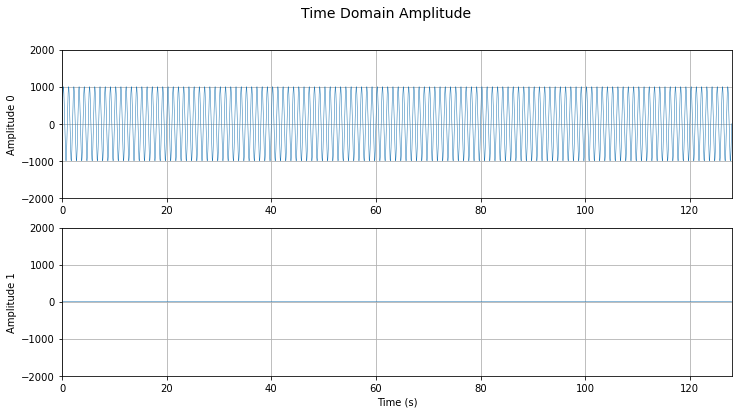

In [4]:
# Simulação das forças NODAIS

Td  = 128
N   = 2**16
F0  = 1000.
f0  = 1.00

t   = np.linspace(0, Td, N)
F1  = F0*np.sin(2*np.pi*f0*t)
F2  = np.zeros_like(F1)

FG  = MRPy(np.vstack((F1, F2)), Td=Td)
FG.plot_time(fig=1, figsize=(12,6), axis_t=[0, FG.Td, -2000, 2000]);


Cálculo dos parâmetros modais, usando a matriz $\Phi$ original (fornecida pelo algoritmo de
autovalores do Python, com a escala que tiver). Abaixo também são calculadas as forças modais.


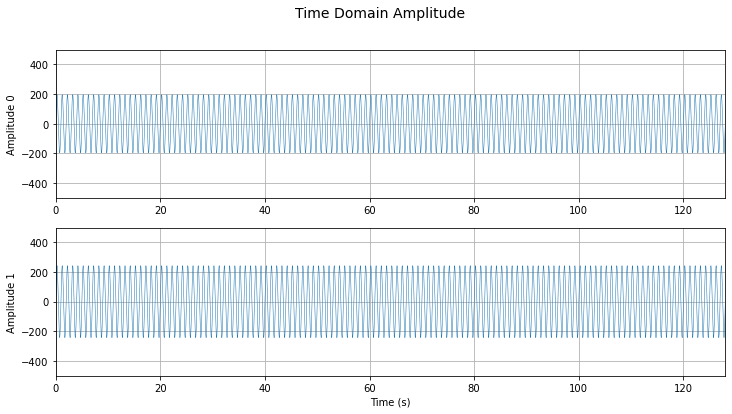

In [5]:
zk = np.array([0.01, 0.01])
Mk = np.diag(np.dot(Phi.T, np.dot(MG, Phi)))
Kk = Mk*(wk**2)
Fk = MRPy(np.dot(Phi.T, FG), fs=FG.fs)

Fk.plot_time(fig=2, figsize=(12,6), axis_t=[0, FG.Td, -500, 500]);


Cálculo dos deslocamentos por superposição MODAL e retorno aos valores NODAIS:

Deslocamento modal de pico do primeiro modo: 28.7mm
Deslocamento modal de pico do segundo modo:  23.1mm

Deslocamento de pico da massa M1:             1.1mm
Deslocamento de pico da massa M2:            50.5mm


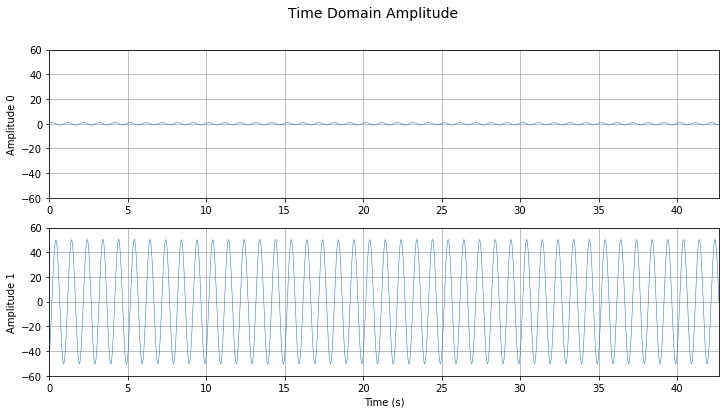

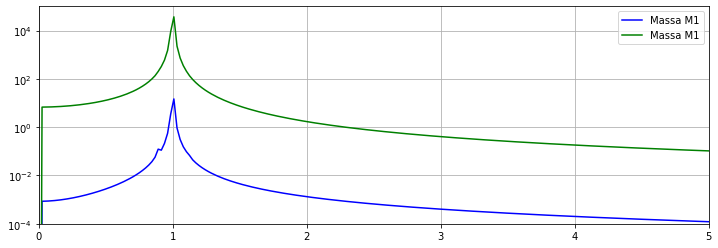

In [6]:
ak  = MRPy(np.dot(np.diag(1/Mk), Fk), fs=Fk.fs)   # divide force by modal mass
uk  = ak.sdof_Duhamel(fk, zk)                     # modal space solution
uG  = 1000*MRPy(np.dot(Phi, uk), fs=uk.fs)        # back to nodal solution
uG  = uG.extract(segm=(2/3, 1), by='fraction')    # avoid transiente start

uG.plot_time(4, figsize=(12,6), axis_t=[0, uG.Td, -60, 60]);

f       = uG.f_axis()
Su, fs  = uG.periodogram()

plt.figure(5, figsize=(12,4))
plt.semilogy(f, Su[0], 'b', f, Su[1], 'g')
plt.axis([0, 5, 1e-4, 1e5])
plt.legend(('Massa M1', 'Massa M1'))
plt.grid(True)


ukp = uk.extract(segm=(3/4, 1), by='fraction').max(axis=1)
up  = uG.max(axis=1)

print('Deslocamento modal de pico do primeiro modo: {0:4.1f}mm'.format(1000*ukp[0]))
print('Deslocamento modal de pico do segundo modo:  {0:4.1f}mm\n'.format(1000*ukp[1]))

print('Deslocamento de pico da massa M1:            {0:4.1f}mm'.format(up[0]))
print('Deslocamento de pico da massa M2:            {0:4.1f}mm'.format(up[1]))


Observa-se que a frequência da carga está situada bem entre as duas frequências naturais, de modo que se evita um
forte pico de ressonância.


#### Método 2: pela função de admitância

As propriedades modais já foram calculadas no método anterior. 
Agora calcula-se a amplitude das forças modais:


In [7]:
FG  = np.array([[F0, 0]]).T     # amplitudes das forças nodais (vetor coluna)
Fk  = np.dot(Phi.T, FG)

Fk1 = Fk[0,0]
Fk2 = Fk[1,0]

print('Amplitude da força modal no primeiro modo: {0:4.1f} N'.format(Fk1))
print('Amplitude da força modal no segundo modo:  {0:4.1f} N'.format(Fk2))


Amplitude da força modal no primeiro modo: 196.1 N
Amplitude da força modal no segundo modo:  242.5 N


A amplitude dos deslocamentos modais é calculada usando-se a função de ganho, $A(\beta, \zeta)$, 
na frequência da excitação $f_0$ (1Hz):


In [8]:
Aw  =  lambda f: np.sqrt(1/( (1 - (f/fn)**2)**2 + (2*zt*(f/fn))**2 ))

fn  =  fk[0]
zt  =  zk[0]
A1  =  Aw(f0)
u1  =  1000*A1*Fk1/Kk[0]

fn  =  fk[1]
zt  =  zk[1]
A2  =  Aw(f0)
u2  =  1000*A2*Fk2/Kk[1]

print('Amplificação dinâmica no primeiro modo: {0:5.2f}'.format(A1))
print('Deslocamento modal no primeiro modo:    {0:5.2f} mm\n'.format(u1))

print('Amplificação dinâmica no segundo modo:  {0:5.2f}'.format(A2))
print('Deslocamento modal no segundo modo:     {0:5.2f}mm'.format(u2))


Amplificação dinâmica no primeiro modo:  3.98
Deslocamento modal no primeiro modo:    28.59 mm

Amplificação dinâmica no segundo modo:   4.98
Deslocamento modal no segundo modo:     23.12mm


Observa-se que os deslocamentos MODAIS coincidem com os valores obtidos por simulação.
Finalmente os deslocamentos MODAIS são superpostos (ignorando-se a fase) para se calcular os deslocamentos NODAIS.
Como a informação de fase é perdida, é feita uma combinação quadrática das amplitudes, que traz alguma imprecisão.


In [9]:
uG = np.sqrt((Phi[:,0]*u1)**2 + (Phi[:,1]*u2)**2)        # Combinação quadrática de amplitudes

print('Deslocamento de pico da massa M1: {0:4.1f}mm'.format(uG[0]))
print('Deslocamento de pico da massa M2: {0:4.1f}mm'.format(uG[1]))


Deslocamento de pico da massa M1:  7.9mm
Deslocamento de pico da massa M2: 35.9mm


Observa-se que os resultados diferem dos obtidos por simulação, onde a fase é levada em conta.


## Questão 3

Para a viga com as restrições de apoio dadas, proponha uma forma aproximada para o primeiro modo de vibração, $\varphi(x)$, e calcule a respectiva frequência natural em função do comprimento, $L$, da massa por unidade de comprimento, $\mu$, e da rigidez à flexão, $EI$.

<img src="resources/tests/PEC00025A_231_P2_Q3.png" alt="Question 3" width="480px"/>  


### Solução:

Vamos usar como modo de vibração a função de interpolação para uma rotação do nó B. Logo:

$$ \phi(\xi) = \xi^3 - \xi^2 $$

onde $\xi = x/L$. A escala da função acima não é importante. A curvatura é a segunda derivada dessa função:

$$ \phi^{\prime \prime}(\xi) = \left( 6\xi - 2 \right)/L^2 $$

Logo a energia cinética de referência é:

$$ 2T_{\rm ref} = \int_0^1{\mu \phi^2(\xi) \; Ld\xi} = \frac{\mu L}{105}$$

e a energia potencial elástica é:

$$ 2V = \int_0^1{EI \left[ \phi^{\prime \prime}(\xi)\right] ^2 \; Ld\xi} = \frac{4EI}{L^3} $$

Portanto, pelo quociente de Rayleigh temos:

$$ f_{\rm n} = \frac{1}{2\pi} \sqrt{\frac{V}{T_{\rm ref}}} = 
               \frac{1}{2\pi} \sqrt{\frac{420EI}{\mu L^4}} = 
               \frac{1}{2\pi} \left( \frac{4.5270}{L} \right)^2 \sqrt{\frac{EI}{\mu}}$$

Na tabela abaixo o resultado exato é encontrado como sendo 3.93 ao invés de 4.53 com a função aproximada.
Lembrando que o quociente de Rayleigh sempre dá uma frequência _acima_ do valor correto.

<img src="images/beams.png" alt="Beam solutions" width="540px"/>

O gráfico abaixo é só para conferir a forma modal aproximada escolhida.


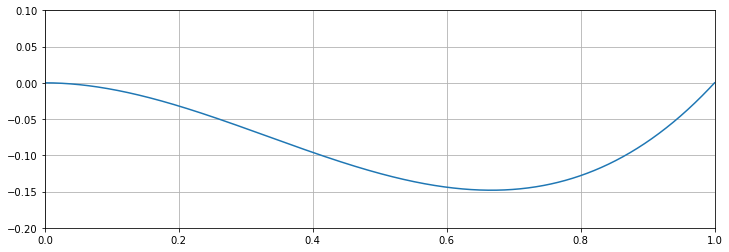

In [10]:
phi = lambda xi: L*(xi*xi*xi - xi*xi)

L   = 1.
x   = np.linspace(0, L, 1024)
phx = phi(x)

plt.figure(6, figsize=(12,4))
plt.plot(x, phx)
plt.axis([0, 1, -0.2, 0.1])
plt.grid(True)


Alternativamente podemos usar a linha elástica que resulta da aplicação de uma carga distribuída sobre
uma viga com as condições de contorno dadas:

$$ \phi(\xi) = 2\xi^4 - 5\xi^3 + 3\xi^2$$

onde $\xi = x/L$. A escala da função acima é irrelevante. A curvatura é a segunda derivada dessa função:

$$ \phi^{\prime \prime}(\xi) = \left( 24\xi^2 - 30\xi + 6 \right)/L^2 $$

Logo a energia cinética de referência é:

$$ 2T_{\rm ref} = \int_0^1{\mu \phi^2(\xi) \; Ld\xi} = \frac{19\mu L}{630}$$

e a energia potencial elástica é:

$$ 2V = \int_0^1{EI \left[ \phi^{\prime \prime}(\xi)\right] ^2 \; Ld\xi} = \frac{36EI}{5L^3} $$

Portanto, pelo quociente de Rayleigh temos:

$$ f_{\rm n} = \frac{1}{2\pi} \sqrt{\frac{V}{T_{\rm ref}}} = 
               \frac{1}{2\pi} \sqrt{\frac{22680EI}{95\mu L^4}} = 
               \frac{1}{2\pi} \left( \frac{3.9308}{L} \right)^2 \sqrt{\frac{EI}{\mu}}$$

Observa-se que essa função de interpolação proposta é (quase) exatamente o valor apresentado na tabela. 

Abaixo está um gráfico para visualização da forma modal proposta.


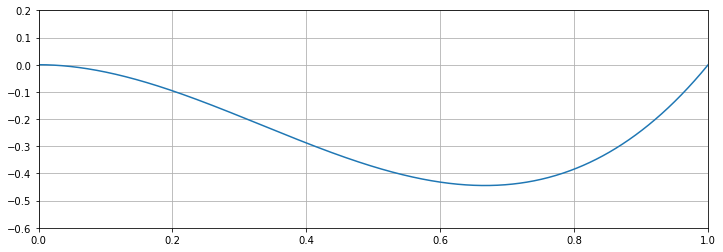

In [11]:
phi = lambda xi: -2*xi*xi*xi + 5*xi*xi*xi - 3*xi*xi

L   = 1.
x   = np.linspace(0, L, 1024)
phx = phi(x)

plt.figure(6, figsize=(12,4))
plt.plot(x, phx)
plt.axis([0, 1, -0.6, 0.2])
plt.grid(True)


## Questão 4

Para a viga do problema anterior, com os valores dados abaixo, calcule a máxima amplitude de deslocamento para o peso próprio sendo aplicado de forma súbita a partir do tempo $t = 0$, ou seja, como uma função passo unitário, $h(t)$.

<img src="resources/tests/PEC00025A_231_P2_Q4.png" alt="Question 4" width="540px"/>  


### Solução

Inicialmente define-se os dados numéricos do problema.


In [12]:
L  = 6.           # comprimento das barras (m)
EI = 48000000.    # rigidez à flexão (Nm2)
μ  = 250.         # massa por unidade de comprimento (kg/m)
g  = 9.81         # gravidade (m/s2)
q  = μ*g          # carga por unidade de comprimento (N/m)


Usando-se a função de interpolação proposta são calculados os valores modais. Primeiro a massa modal:

$$ M_k = \int_0^1{\mu \phi^2(\xi) \; Ld\xi} = \frac{19\mu L}{630} \approx 45.2{\rm kg}$$

e em seguida a frequência modal:

$$ w_k = \left( \frac{3.931}{L} \right)^2 \sqrt{\frac{EI}{\mu}} \approx 188.1{\rm rad/s} \approx 29.93{\rm Hz}$$

com as quais calculamos a rigidez modal:

$$ K_k = \omega_k^2 M_k \approx 1600{\rm kN/m} $$

A amplitude da força modal (passo unitário) é calculada a partir da forma modal:

$$ F_k = \int_0^1{\mu g \phi(\xi) \; Ld\xi} = \frac{3}{20} \mu g L \approx 2.21{\rm kN} $$

A amplificação dinâmica para uma carga passo unitário é $A = 2$, que deve ser aplicada sobre
o deslocamento modal estático:

$$ u_{k, {\rm dyn}} = A u_{k, {\rm est}} = A \frac{F_k}{K_k} = 2 \cdot \frac{2.21}{1600} = 2.76{\rm mm}$$

A máxima amplitude da forma modal é calculada como sendo $\phi_{\rm max} \approx 0.26$. 
Portanto a máxima amplitude de deslocamento é dada por:

$$ u_{\max} = \phi_{\rm max} u_{k, {\rm dyn}} \approx 0.72{\rm mm} $$.
